
# AIRD ML Inference 예시

이 노트북은 이미 학습된 모델 파일(`.pkl`) 을 활용하여,  
3개의 ML Pack에 대해 **재학습 없이 바로 예측·평가·저장**하는 예제입니다.


## 1. 환경 설정 및 경로 자동 인식
첫 셀 실행 후 런타임 재시작 해야합니다.

In [1]:
import os

def is_colab():
    """현재 실행 환경이 Google Colab인지 확인"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    print("▶ Colab 환경입니다.")

    # ------------------------
    # 1) GitHub Repo Clone
    # ------------------------
    repo_url = "https://github.com/hike-lab/AIRD-PACK.git"
    repo_name = repo_url.split('/')[-1].replace('.git', '')

    if os.path.exists(repo_name):
        print(f"이미 '{repo_name}' 폴더가 있어 clone을 스킵합니다.")
    else:
        print("GitHub repo clone 중...")
        !git clone $repo_url
        print("clone 완료!")

    # ------------------------
    # 2) 한글 폰트 설치
    # ------------------------
    print("나눔 폰트 설치 중...")
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    print("폰트 설치 완료! (런타임 재시작 필요)")

    # ------------------------
    # 3) requirements 설치
    # ------------------------
    print("requirements.txt 설치 중...")
    %cd $repo_name
    !pip install -r requirements.txt
    %cd ..

    # ------------------------
    # 4) Colab용 경로 설정
    # ------------------------
    RAW_DATA_PATH = f"{repo_name}/data/raw/"
    PROCESSED_DATA_PATH = f"{repo_name}/data/processed/"
    OUTPUT_PATH = f"{repo_name}/code/ml-pack/outputs/"

    print("폴더 경로 설정 완료!")
    print("RAW_DATA_PATH:", RAW_DATA_PATH)
    print("PROCESSED_DATA_PATH:", PROCESSED_DATA_PATH)
    print("OUTPUT_PATH:", OUTPUT_PATH)

else:
    RAW_DATA_PATH = "../../data/raw/"
    PROCESSED_DATA_PATH = "../../data/processed/"
    OUTPUT_PATH = "../../code/ml-pack/outputs/"
    print("▶ 로컬 환경입니다. git clone 및 폰트 설치는 실행하지 않습니다.")

    print("로컬 경로 설정 완료!")
    print("RAW_DATA_PATH:", RAW_DATA_PATH)
    print("PROCESSED_DATA_PATH:", PROCESSED_DATA_PATH)
    print("OUTPUT_PATH:", OUTPUT_PATH)

▶ 로컬 환경입니다. git clone 및 폰트 설치는 실행하지 않습니다.
로컬 경로 설정 완료!
RAW_DATA_PATH: ../../data/raw/
PROCESSED_DATA_PATH: ../../data/processed/
OUTPUT_PATH: ../../code/ml-pack/outputs/


In [2]:
from pathlib import Path
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score,
)

# 폰트 설정
import matplotlib.font_manager as fm


def set_korean_font():
    """
    플랫폼 판별 및 폰트 다운로드 없이
    matplotlib에 이미 설치된 한글 폰트만 사용
    """

    candidate_fonts = [
        "Malgun Gothic",      # Windows
        "AppleGothic",        # macOS
        "NanumGothic",        # Linux / 일부 Colab
        "Noto Sans CJK KR",
        "Noto Sans KR"
    ]

    installed_fonts = {f.name for f in fm.fontManager.ttflist}
    for font in candidate_fonts:
        if font in installed_fonts:
            plt.rcParams["font.family"] = font
            plt.rcParams["axes.unicode_minus"] = False
            print(f"✅ 한글 폰트 적용: {font}")
            return

# 실행
set_korean_font()


✅ 한글 폰트 적용: AppleGothic


## 2. 모델 로더 정의

In [3]:
# joblib 우선, 실패 시 pickle로 재시도하는 안전한 모델 로더

try:
    from joblib import load as joblib_load
    HAS_JOBLIB = True
except ImportError:
    HAS_JOBLIB = False

def load_model(path: Path):
    """joblib 또는 pickle로 저장된 모델 파일을 로드.

    1) joblib이 설치되어 있으면 joblib으로 먼저 시도
    2) 실패하면 pickle.load()로 재시도
    """
    if not path.exists():
        print(f"⚠ 모델 파일이 존재하지 않습니다: {path}")
        return None

    # 1) joblib 시도
    if HAS_JOBLIB:
        try:
            model = joblib_load(path)
            print(f"✅ joblib으로 모델 로드 완료: {path.name}")
            return model
        except Exception as e:
            print(f"ℹ joblib 로드 실패, pickle로 재시도: {e}")

    # 2) pickle 시도
    try:
        with open(path, "rb") as f:
            model = pickle.load(f)
        print(f"✅ pickle로 모델 로드 완료: {path.name}")
        return model
    except Exception as e:
        print(f"❌ 모델 로드 실패: {e}")
        return None



## 3. 공장 단위 리스크 예측 (factory_risk_rf_model / factory_risk_xgb_model)

- 입력 데이터: `ml_factory_risk_seoul_2025_v1.csv`  
- 사용 모델:
  - `factory_risk_rf_model.pkl`  
  - `factory_risk_xgb_model.pkl`

- Feature:
  - `feature_base_age` : 공장연령
  - `feature_base_area_log` : 공장 면적
  - `feature_base_gu_density` : 자치구 밀집도
  - `feature_agg_dong_factory_count` : 해당 동의 공장 수

- Label: `label_high_risk` : 공장의 위험도


In [4]:
factory_csv =  f"{PROCESSED_DATA_PATH}ml_factory_risk_seoul_2025_v1.csv"
df_factory = pd.read_csv(factory_csv)
print("공장 리스크 데이터:", df_factory.shape)
df_factory.drop_duplicates().head()


공장 리스크 데이터: (16192, 11)


,factory_id,company_name,region_gu,region_dong,feature_base_age,feature_base_area,feature_base_area_log,feature_base_gu_density,feature_agg_dong_factory_count,risk_score,label_high_risk
0,111100000000003,(주)에취.알.디,종로구,통의동,27.0,79.11,4.383401,0.037022,4,0.281215,0
2,111100000000002,(주)코리아쉬핑가제트,종로구,통의동,27.0,92.40,4.536891,0.037022,4,0.286694,0
4,111100000000005,중앙인쇄사,종로구,적선동,27.0,55.00,4.025352,0.037022,5,0.268434,0
6,570601205741701,사회교육문화사,종로구,통인동,27.0,125.00,4.836282,0.037022,11,0.297381,0
8,111100000000011,(주)계문사,종로구,필운동,27.0,93.05,4.543827,0.037022,5,0.286941,0


In [5]:
# 사용 Feature / Label 정의 (학습 시 사용한 것과 동일해야 함)
factory_feature_cols = [
    "feature_base_age",
    "feature_base_area_log",
    "feature_base_gu_density",
    "feature_agg_dong_factory_count",
]
factory_feature_cols = [c for c in factory_feature_cols if c in df_factory.columns]

factory_label_col = "label_high_risk" if "label_high_risk" in df_factory.columns else None

print("Feature 컬럼:", factory_feature_cols)
print("Label 컬럼  :", factory_label_col)

X_f = df_factory[factory_feature_cols]
y_f = df_factory[factory_label_col] if factory_label_col else None


Feature 컬럼: ['feature_base_age', 'feature_base_area_log', 'feature_base_gu_density', 'feature_agg_dong_factory_count']
Label 컬럼  : label_high_risk


RF 모델 경로: ../../code/ml-pack/outputs/models/factory_risk_rf_model.pkl
✅ joblib으로 모델 로드 완료: factory_risk_rf_model.pkl
사용 Feature 컬럼: ['factory_id', 'feature_base_age', 'feature_base_area', 'feature_base_area_log', 'feature_base_gu_density', 'feature_agg_dong_factory_count', 'risk_score']
✅ RandomForest 예측 완료

[RandomForest - 공장 리스크 예측 성능]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     12143
           1      1.000     1.000     1.000      4049

    accuracy                          1.000     16192
   macro avg      1.000     1.000     1.000     16192
weighted avg      1.000     1.000     1.000     16192

ROC AUC: 1.0


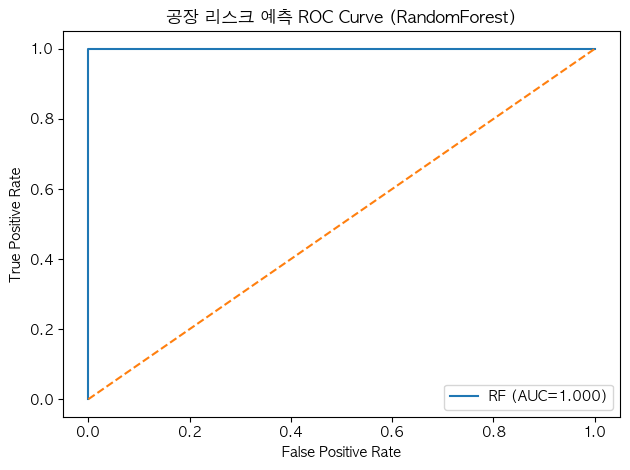

Confusion Matrix:
 [[12143     0]
 [    0  4049]]


In [6]:
# === RandomForest 모델 로드 ===
rf_path_pkl = Path(OUTPUT_PATH) / "models/factory_risk_rf_model.pkl"

rf_path = rf_path_pkl
print("RF 모델 경로:", rf_path)

rf_model = load_model(rf_path) if rf_path.exists() else None

if rf_model is not None:
    # 1) 모델이 학습할 때 사용한 feature 목록을 그대로 사용
    if hasattr(rf_model, "feature_names_in_"):
        model_feature_cols = [c for c in rf_model.feature_names_in_ if c in df_factory.columns]
        missing = set(rf_model.feature_names_in_) - set(model_feature_cols)
        if missing:
            print("⚠ 데이터에 없는 feature 컬럼(학습 시 사용됨):", missing)
        X_f = df_factory[model_feature_cols]
    else:
        # 구버전 sklearn 등에서 fallback
        model_feature_cols = [
            "feature_base_age",
            "feature_base_area_log",
            "feature_base_gu_density",
            "feature_agg_dong_factory_count",
        ]
        model_feature_cols = [c for c in model_feature_cols if c in df_factory.columns]
        X_f = df_factory[model_feature_cols]

    # 2) Label (있으면)
    factory_label_col = "label_high_risk" if "label_high_risk" in df_factory.columns else None
    y_f = df_factory[factory_label_col] if factory_label_col else None

    print("사용 Feature 컬럼:", model_feature_cols)

    # 3) 예측
    df_factory["pred_rf_label"] = rf_model.predict(X_f)
    if hasattr(rf_model, "predict_proba"):
        df_factory["pred_rf_prob"] = rf_model.predict_proba(X_f)[:, 1]
    print("✅ RandomForest 예측 완료")

    # 4) 성능 평가 (Label 있을 때만)
    if y_f is not None:
        print("\n[RandomForest - 공장 리스크 예측 성능]")
        print(classification_report(y_f, df_factory["pred_rf_label"], digits=3))

        if "pred_rf_prob" in df_factory.columns:
            auc = roc_auc_score(y_f, df_factory["pred_rf_prob"])
            print("ROC AUC:", round(auc, 3))

            fpr, tpr, _ = roc_curve(y_f, df_factory["pred_rf_prob"])
            plt.figure()
            plt.plot(fpr, tpr, label=f"RF (AUC={auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("공장 리스크 예측 ROC Curve (RandomForest)")
            plt.legend()
            plt.tight_layout()
            plt.savefig(Path(OUTPUT_PATH) / "figures/factory_rf_roc_curve.png")
            plt.show()

        cm = confusion_matrix(y_f, df_factory["pred_rf_label"])
        print("Confusion Matrix:\n", cm)
else:
    print("⚠ RandomForest 공장 리스크 모델이 없어 해당 섹션을 건너뜁니다.")


XGB 모델 경로: ../../code/ml-pack/outputs/models/factory_risk_xgb_model.pkl
✅ joblib으로 모델 로드 완료: factory_risk_xgb_model.pkl
✅ XGBoost 예측 완료

[XGBoost - 공장 리스크 예측 성능]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     12143
           1      1.000     1.000     1.000      4049

    accuracy                          1.000     16192
   macro avg      1.000     1.000     1.000     16192
weighted avg      1.000     1.000     1.000     16192

ROC AUC: 1.0


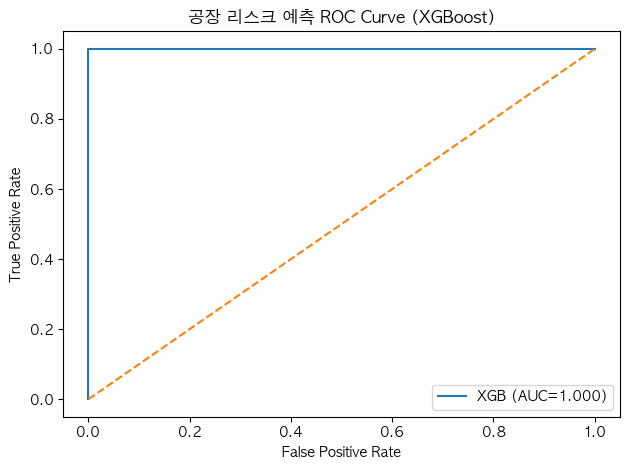

In [7]:
# === XGBoost 모델 로드 및 예측 (선택) ===
xgb_path_pkl = Path(OUTPUT_PATH) / "models/factory_risk_xgb_model.pkl"

xgb_path = xgb_path_pkl
print("XGB 모델 경로:", xgb_path)

xgb_model = load_model(xgb_path) if xgb_path.exists() else None

if xgb_model is not None:
    df_factory["pred_xgb_label"] = xgb_model.predict(X_f)
    if hasattr(xgb_model, "predict_proba"):
        df_factory["pred_xgb_prob"] = xgb_model.predict_proba(X_f)[:, 1]
    print("✅ XGBoost 예측 완료")

    # 성능 평가 (Label 있을 때만)
    if y_f is not None and "pred_xgb_label" in df_factory.columns:
        print("\n[XGBoost - 공장 리스크 예측 성능]")
        print(classification_report(y_f, df_factory["pred_xgb_label"], digits=3))

        if "pred_xgb_prob" in df_factory.columns:
            auc = roc_auc_score(y_f, df_factory["pred_xgb_prob"])
            print("ROC AUC:", round(auc, 3))

            fpr, tpr, _ = roc_curve(y_f, df_factory["pred_xgb_prob"])
            plt.figure()
            plt.plot(fpr, tpr, label=f"XGB (AUC={auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("공장 리스크 예측 ROC Curve (XGBoost)")
            plt.legend()
            plt.tight_layout()
            plt.savefig(Path(OUTPUT_PATH) / "figures/factory_xgb_roc_curve.png")
            plt.show()
else:
    print("ℹ XGBoost 모델이 없는 경우, RandomForest만 사용해도 충분합니다.")


In [8]:
# 공장 리스크 예측 결과 저장 (RF 기준)
factory_pred_csv = Path(OUTPUT_PATH) / "predictions/factory_risk_predictions_2025_rf.csv"
df_factory.to_csv(factory_pred_csv, index=False, encoding="utf-8-sig")

print("✅ 공장 리스크 예측 결과 저장:", factory_pred_csv)
df_factory.head(5)


✅ 공장 리스크 예측 결과 저장: ../../code/ml-pack/outputs/predictions/factory_risk_predictions_2025_rf.csv


,factory_id,company_name,region_gu,region_dong,feature_base_age,feature_base_area,feature_base_area_log,feature_base_gu_density,feature_agg_dong_factory_count,risk_score,label_high_risk,pred_rf_label,pred_rf_prob,pred_xgb_label,pred_xgb_prob
0,111100000000003,(주)에취.알.디,종로구,통의동,27.0,79.11,4.383401,0.037022,4,0.281215,0,0,0.0,0,0.000105
1,111100000000003,(주)에취.알.디,종로구,통의동,27.0,79.11,4.383401,0.037022,4,0.281215,0,0,0.0,0,0.000105
2,111100000000002,(주)코리아쉬핑가제트,종로구,통의동,27.0,92.40,4.536891,0.037022,4,0.286694,0,0,0.0,0,0.000105
3,111100000000002,(주)코리아쉬핑가제트,종로구,통의동,27.0,92.40,4.536891,0.037022,4,0.286694,0,0,0.0,0,0.000105
4,111100000000005,중앙인쇄사,종로구,적선동,27.0,55.00,4.025352,0.037022,5,0.268434,0,0,0.0,0,0.000105



## 4. 자치구 단위 노후공장비율 높음/낮음 예측 (region_rf_model)

- 입력 데이터: `ml_region_old_factory_share_seoul_2025_v1.csv`  
- 사용 모델: `region_rf_model.pkl`  

- Feature:
  - `feature_factory_count` : 공장 수
  - `feature_old_factory_count` : 노후공장 수
  - `feature_old_share` : 노후공장 비율
  - `feature_avg_age` : 평균 공장연령
  - `feature_avg_area_log` : 평균 면적 로그
  - `feature_dong_count` : 공장이 존재하는 동 개수
- Label:
  - `label_high_old_share` : 노후공장 비율 높음/낮음 (이진 분류)


In [9]:
region_csv = Path(PROCESSED_DATA_PATH) / "ml_region_old_factory_share_seoul_2025_v1.csv"
df_region = pd.read_csv(region_csv)
print("자치구 데이터:", df_region.shape)
df_region.head(5)


자치구 데이터: (25, 8)


,region_gu,feature_avg_age,feature_old_factory_count,feature_factory_count,feature_avg_area_log,feature_old_share,feature_dong_count,label_high_old_share
0,강남구,19.615385,14,561,4.310796,0.024955,14,0
1,강동구,27.000000,41,204,4.706014,0.200980,8,1
2,강북구,23.714286,23,240,4.603265,0.095833,5,0
3,강서구,22.194004,444,2031,4.655124,0.218612,25,1
4,관악구,21.285714,4,152,4.453256,0.026316,6,0


In [10]:
region_feature_cols = [
    "feature_factory_count",
    "feature_old_factory_count",
    "feature_avg_age",
    "feature_avg_area_log",
    "feature_dong_count",
]
region_feature_cols = [c for c in region_feature_cols if c in df_region.columns]

label_region_cls = "label_high_old_share" if "label_high_old_share" in df_region.columns else None
label_region_reg = "feature_old_share" if "feature_old_share" in df_region.columns else None

print("Feature 컬럼:", region_feature_cols)
print("분류 Label:", label_region_cls, "/ 회귀 Target:", label_region_reg)

X_r = df_region[region_feature_cols]


Feature 컬럼: ['feature_factory_count', 'feature_old_factory_count', 'feature_avg_age', 'feature_avg_area_log', 'feature_dong_count']
분류 Label: label_high_old_share / 회귀 Target: feature_old_share


Region 모델 경로: ../../code/ml-pack/outputs/models/region_rf_model.pkl
✅ joblib으로 모델 로드 완료: region_rf_model.pkl
사용 Feature 컬럼: ['feature_avg_age', 'feature_old_factory_count', 'feature_factory_count', 'feature_avg_area_log', 'feature_old_share', 'feature_dong_count']

[자치구 RF 분류 모델 평가]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        17
           1      1.000     1.000     1.000         8

    accuracy                          1.000        25
   macro avg      1.000     1.000     1.000        25
weighted avg      1.000     1.000     1.000        25


[Confusion Matrix]
[[17  0]
 [ 0  8]]

ROC-AUC: 1.000


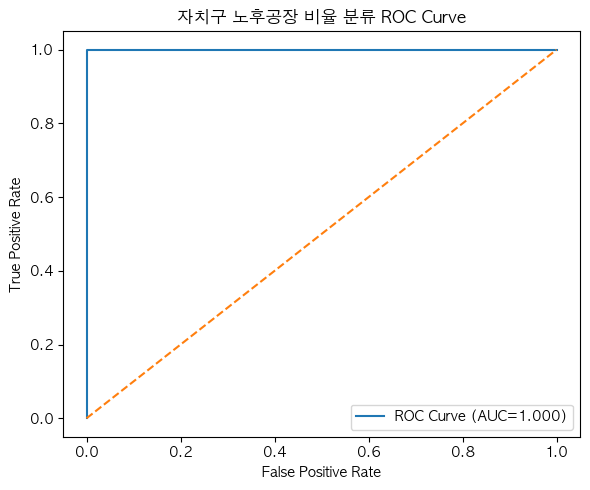

In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

region_path_pkl = Path(OUTPUT_PATH) / "models/region_rf_model.pkl"
region_path = region_path_pkl
print("Region 모델 경로:", region_path)

region_model = load_model(region_path) if region_path.exists() else None

if region_model is None:
    print("⚠ 자치구 RF 모델이 없어 해당 섹션을 건너뜁니다.")
else:
    # =====================================================
    # 1) 모델 Feature 정렬
    # =====================================================
    if hasattr(region_model, "feature_names_in_"):
        region_feature_cols_model = [
            c for c in region_model.feature_names_in_
            if c in df_region.columns
        ]
        missing = set(region_model.feature_names_in_) - set(region_feature_cols_model)
        if missing:
            print("⚠ 데이터에 없는 feature 컬럼:", missing)
        X_r = df_region[region_feature_cols_model]
    else:
        # 구버전 fallback
        fallback_cols = [
            "feature_factory_count",
            "feature_old_factory_count",
            "feature_avg_age",
            "feature_avg_area_log",
            "feature_dong_count",
            "feature_old_share",
        ]
        region_feature_cols_model = [c for c in fallback_cols if c in df_region.columns]
        X_r = df_region[region_feature_cols_model]

    print("사용 Feature 컬럼:", region_feature_cols_model)

    # =====================================================
    # 2) 모델 타입에 따른 분기
    # =====================================================

    # --------- (A) 분류 모델(RandomForestClassifier) ---------
    if isinstance(region_model, RandomForestClassifier):

        print("\n[자치구 RF 분류 모델 평가]")

        # (1) 예측
        preds = region_model.predict(X_r)
        probs = region_model.predict_proba(X_r)[:, 1]  # positive class 확률

        # (2) 실제 분류 라벨
        if label_region_cls is None:
            raise ValueError("❌ label_region_cls(이진 분류 라벨)가 필요합니다.")
        y_cls = df_region[label_region_cls]

        # (3) Classification Report
        print(classification_report(y_cls, preds, digits=3))

        # (4) Confusion Matrix
        print("\n[Confusion Matrix]")
        print(confusion_matrix(y_cls, preds))

        # (5) ROC-AUC
        auc = roc_auc_score(y_cls, probs)
        print(f"\nROC-AUC: {auc:.3f}")

        # (6) ROC Curve 시각화
        fpr, tpr, _ = roc_curve(y_cls, probs)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("자치구 노후공장 비율 분류 ROC Curve")
        plt.legend()
        plt.tight_layout()
        plt.savefig(Path(OUTPUT_PATH) / "figures/region_rf_roc_curve.png")
        plt.show()

    else:
        print("⚠ 예상치 못한 모델 타입입니다:", type(region_model))

In [12]:
# 자치구 노후공장 비율 예측 결과 저장

save_cols = []

df_region["pred_region_proba"] = probs
df_region["pred_region_label"] = preds

# 지역명
if "region_gu" in df_region.columns:
    save_cols.append("region_gu")

# 실제 이진 라벨
if label_region_cls is not None:
    save_cols.append(label_region_cls)

# 실제 노후공장 비율 (보조 분석용)
if "feature_old_share" in df_region.columns:
    save_cols.append("feature_old_share")

# 예측 확률 + 예측 라벨
if "pred_region_proba" in df_region.columns:
    save_cols.append("pred_region_proba")
if "pred_region_label" in df_region.columns:
    save_cols.append("pred_region_label")

# 저장용 DF
df_save = df_region[save_cols].copy()

# 정렬: 예측 확률 높은 순
df_save = df_save.sort_values("pred_region_proba", ascending=False)

region_pred_csv = Path(OUTPUT_PATH) / "predictions/region_old_share_predictions_2025_rf.csv"
df_save.to_csv(region_pred_csv, index=False, encoding="utf-8-sig")

df_save

,region_gu,label_high_old_share,feature_old_share,pred_region_proba,pred_region_label
15,성동구,1,0.267091,0.96,1
22,종로구,1,0.184971,0.94,1
3,강서구,1,0.218612,0.92,1
20,용산구,1,0.178161,0.86,1
1,강동구,1,0.200980,0.86,1
18,양천구,1,0.167665,0.84,1
23,중구,1,0.338892,0.82,1
13,서대문구,1,0.218750,0.72,1
19,영등포구,0,0.145765,0.18,0
9,도봉구,0,0.139623,0.18,0



## 5. 동 단위 제조업 Hotspot 예측 (location_rf_model)

- 입력 데이터: `ml_location_score_candidate_sites_v1.csv`  
- 사용 모델: `location_rf_model.pkl` 또는 `.joblib`  

주요 Feature 예시:

- `feature_factory_count`  
- `feature_old_share`  
- `feature_gu_density`  
- `feature_avg_age`  
- `feature_avg_area_log`  

Label:

- `label_hotspot` (Hotspot 여부)


In [13]:

location_csv = Path(PROCESSED_DATA_PATH) / "ml_location_score_candidate_sites_v1.csv"
df_loc = pd.read_csv(location_csv)
print("동 단위 데이터:", df_loc.shape)
df_loc.head(5)


동 단위 데이터: (358, 8)


,region_gu,region_dong,feature_avg_age,feature_old_share,feature_factory_count,feature_avg_area_log,feature_gu_density,label_hotspot
0,강남구,개포동,NaN,0.0,46,4.365898,0.040508,1
1,강남구,논현동,15.0,0.0,95,4.291453,0.040508,1
2,강남구,대치동,12.0,0.0,64,4.334614,0.040508,1
3,강남구,도곡동,NaN,0.0,38,4.412931,0.040508,0
4,강남구,도곡제2동,NaN,0.0,3,3.895284,0.040508,0


In [14]:

loc_feature_cols = [
    "feature_factory_count",
    "feature_old_share",
    "feature_gu_density",
    "feature_avg_age",
    "feature_avg_area_log",
]
loc_feature_cols = [c for c in loc_feature_cols if c in df_loc.columns]

loc_label_col = "label_hotspot" if "label_hotspot" in df_loc.columns else None

print("Feature 컬럼:", loc_feature_cols)
print("Label 컬럼  :", loc_label_col)

X_l = df_loc[loc_feature_cols]
y_l = df_loc[loc_label_col] if loc_label_col else None


Feature 컬럼: ['feature_factory_count', 'feature_old_share', 'feature_gu_density', 'feature_avg_age', 'feature_avg_area_log']
Label 컬럼  : label_hotspot


Location 모델 경로: ../../code/ml-pack/outputs/models/location_rf_model.pkl
✅ joblib으로 모델 로드 완료: location_rf_model.pkl
사용 Feature 컬럼: ['feature_avg_age', 'feature_old_share', 'feature_factory_count', 'feature_avg_area_log', 'feature_gu_density']
✅ 동 단위 Hotspot 예측 완료

[동 단위 Hotspot 분류 성능]
              precision    recall  f1-score   support

           0      0.996     1.000     0.998       268
           1      1.000     0.989     0.994        90

    accuracy                          0.997       358
   macro avg      0.998     0.994     0.996       358
weighted avg      0.997     0.997     0.997       358

ROC AUC: 1.0


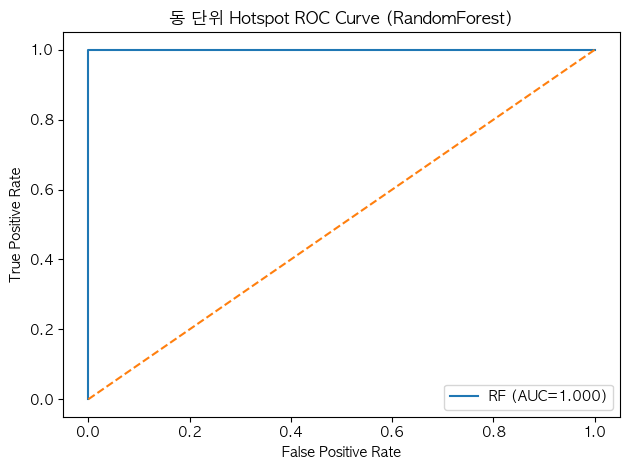

Confusion Matrix:
 [[268   0]
 [  1  89]]


In [15]:
loc_path_pkl = Path(OUTPUT_PATH) / "models/location_rf_model.pkl"
loc_path_joblib = Path(OUTPUT_PATH) / "models/location_rf_model.joblib"
loc_path = loc_path_pkl if loc_path_pkl.exists() else loc_path_joblib
print("Location 모델 경로:", loc_path)

loc_model = load_model(loc_path) if loc_path.exists() else None

if loc_model is not None:
    # 1) 모델이 학습 당시 사용한 feature 목록을 그대로 사용
    if hasattr(loc_model, "feature_names_in_"):
        loc_feature_cols_model = [
            c for c in loc_model.feature_names_in_
            if c in df_loc.columns
        ]
        missing = set(loc_model.feature_names_in_) - set(loc_feature_cols_model)
        if missing:
            print("⚠ 데이터에 없는 feature 컬럼(학습 시 사용됨):", missing)
        X_l = df_loc[loc_feature_cols_model]
    else:
        # feature_names_in_이 없을 경우 fallback (임시)
        loc_feature_cols_model = [
            "feature_factory_count",
            "feature_old_share",
            "feature_gu_density",
            "feature_avg_age",
            "feature_avg_area_log",
        ]
        loc_feature_cols_model = [c for c in loc_feature_cols_model if c in df_loc.columns]
        X_l = df_loc[loc_feature_cols_model]

    print("사용 Feature 컬럼:", loc_feature_cols_model)

    # 2) 예측
    df_loc["pred_loc_label"] = loc_model.predict(X_l)
    if hasattr(loc_model, "predict_proba"):
        df_loc["pred_loc_prob"] = loc_model.predict_proba(X_l)[:, 1]
    print("✅ 동 단위 Hotspot 예측 완료")

    # 3) 성능 평가 (y_l 있는 경우)
    if y_l is not None:
        print("\n[동 단위 Hotspot 분류 성능]")
        print(classification_report(y_l, df_loc["pred_loc_label"], digits=3))

        if "pred_loc_prob" in df_loc.columns:
            auc = roc_auc_score(y_l, df_loc["pred_loc_prob"])
            print("ROC AUC:", round(auc, 3))

            fpr, tpr, _ = roc_curve(y_l, df_loc["pred_loc_prob"])
            plt.figure()
            plt.plot(fpr, tpr, label=f"RF (AUC={auc:.3f})")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("동 단위 Hotspot ROC Curve (RandomForest)")
            plt.legend()
            plt.tight_layout()
            plt.savefig(Path(OUTPUT_PATH) / "figures/location_hotspot_roc_curve.png")
            plt.show()

        cm = confusion_matrix(y_l, df_loc["pred_loc_label"])
        print("Confusion Matrix:\n", cm)
else:
    print("⚠ 동 단위 RF 모델이 없어 해당 섹션을 건너뜁니다.")


In [16]:
# Hotspot 상위 동 Top 30 및 저장
if "pred_loc_prob" in df_loc.columns:
    top_dong = (
        df_loc
        .sort_values("pred_loc_prob", ascending=False)
        .head(30)
    )
    cols = []
    if "region_gu" in df_loc.columns:
        cols.append("region_gu")
    if "region_dong" in df_loc.columns:
        cols.append("region_dong")
    cols += ["feature_factory_count", "feature_old_share", "pred_loc_prob"]
    print("📌 예측 Hotspot 확률이 높은 동 Top 30")
    display(top_dong[cols])

loc_pred_csv = Path(OUTPUT_PATH) / "predictions/location_hotspot_predictions_2025_rf.csv"
df_loc.to_csv(loc_pred_csv, index=False, encoding="utf-8-sig")
print("✅ 동 단위 Hotspot 예측 결과 저장:", loc_pred_csv)


📌 예측 Hotspot 확률이 높은 동 Top 30


,region_gu,region_dong,feature_factory_count,feature_old_share,pred_loc_prob
44,강서구,염창동,279,0.193548,1.000000
204,송파구,가락동,147,0.040816,1.000000
27,강서구,가양동,425,0.145882,1.000000
65,광진구,중곡동,177,0.000000,1.000000
346,중랑구,망우동,185,0.075676,1.000000
90,노원구,상계동,72,0.083333,1.000000
214,송파구,오금동,81,0.000000,1.000000
348,중랑구,면목동,351,0.131054,1.000000
350,중랑구,묵동,57,0.175439,1.000000
9,강남구,신사동,54,0.037037,1.000000


✅ 동 단위 Hotspot 예측 결과 저장: ../../code/ml-pack/outputs/predictions/location_hotspot_predictions_2025_rf.csv



## 6. 학습한 모델을 활용하여 추론

이 노트북에서는 다음을 수행했습니다.

3개의 ML Pack에 대해:
   - 공장 단위 리스크 예측
   - 자치구별 노후공장 비율 높음/낮음 예측
   - 동 단위 제조업 Hotspot 예측 및 Top 30 동 추출
   
이와 같이, 이용자는 AIRD Pack에서 제공하는 **ML Dataset + 학습된 모델**을 활용하여 추가 학습 없이 바로 ML 기반 추론, 분석을 수행할 수 있습니다.
